### Import necessary packages

In [1]:
!pip install pennylane-sf --upgrade
!pip install tensornetwork
!pip install qutip

Requirement already up-to-date: pennylane-sf in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
import tensorflow as tf
import pennylane as qml
from pennylane.qnodes import PassthruQNode

import scipy as sp

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np

import qutip as qt
from qutip import Bloch, basis

### Run one iteration for QNG and for vanilla GD

In [0]:
dev = qml.device('default.qubit', wires=1)

def circuit(params, wires=0):
  qml.RX(params[0], wires=wires)
  qml.RY(params[1], wires=wires)

qnode = PassthruQNode(circuit, dev)

In [0]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)
cost_fn = qml.VQECost(circuit, H, dev)

init_params = np.random.uniform(low=0, high=2*np.pi, size=2)

In [0]:
step_size = 0.01
max_iterations = 500
conv_tol = 1e-06
print_freq = 20

In [6]:
qng_energies_block = []
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params
prev_energy = cost_fn(params)
qng_all_states = []
qng_all_params = []

prev_energy = cost_fn(params)
for n in range(max_iterations):

    # qng step
    params = opt.step(cost_fn, params)

    qng_all_params.append(params)

    # update parameters
    energy = cost_fn(params)
    qng_energies_block.append(energy)

    # calculate difference of new energy versus previous energy (ie, convergence)
    conv = np.abs(energy - prev_energy)

    # append all the statevectors 
    state_step = dev._state
    qng_all_states.append(state_step)

    if n % 20 == 0:
        print('Iteration = {:}'.format(n) ,'Energy = {:.8f} Ha,'.format(energy), 'Convergence parameter = {'
              ':.8f} Ha'.format(conv), "State", state_step)

    if conv <= conv_tol:
        break

    prev_energy = energy
    
    qng_state_final = dev._state

    qng_steps = n

print()
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print("Final state", qng_state_final)
print()
print('Number of iterations = ', qng_steps)

Iteration = 0 Energy = -0.36150402 Ha, Convergence parameter = 0.07838048 Ha State [-0.45323091+0.51521307j -0.37442297-0.62365429j]
Iteration = 20 Energy = -1.25744593 Ha, Convergence parameter = 0.01810272 Ha State [-0.2109208 +0.40799581j -0.09746585-0.88292256j]
Iteration = 40 Energy = -1.39809875 Ha, Convergence parameter = 0.00197698 Ha State [-0.0685414 +0.3924898j  -0.02934541-0.91672934j]
Iteration = 60 Energy = -1.41263592 Ha, Convergence parameter = 0.00019473 Ha State [-0.02152176+0.38596736j -0.00900731-0.92221737j]
Iteration = 80 Energy = -1.41405987 Ha, Convergence parameter = 0.00001898 Ha State [-0.00672452+0.38373075j -0.00279441-0.92341631j]
Iteration = 100 Energy = -1.41419860 Ha, Convergence parameter = 0.00000185 Ha State [-0.00209905+0.38301246j -0.00087033-0.92374038j]

Final value of the ground-state energy = -1.41420612 Ha

Final state [-0.00156888+0.38292954j -0.00065034-0.92377599j]

Number of iterations =  105


In [7]:
vanilla_energies = []
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params
prev_energy = cost_fn(params)
vanilla_all_states = []
vanilla_all_params = []

prev_energy = cost_fn(params)
for n in range(max_iterations):

    # qng step
    params = opt.step(cost_fn, params)

    vanilla_all_params.append(params)

    # update parameters
    energy = cost_fn(params)
    vanilla_energies.append(energy)

    # calculate difference of new energy versus previous energy (ie, convergence)
    conv = np.abs(energy - prev_energy)

    # append all the statevectors 
    state_step = dev._state
    vanilla_all_states.append(state_step)

    if n % 20 == 0:
        print('Iteration = {:}'.format(n) ,'Energy = {:.8f} Ha,'.format(energy), 'Convergence parameter = {'
              ':.8f} Ha'.format(conv), "State", state_step)

    if conv <= conv_tol:
        break

    prev_energy = energy
    
    vanilla_state_final = dev._state

    vanilla_steps = n

print()
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print("Final state", vanilla_state_final)
print()
print('Number of iterations = ', vanilla_steps)

Iteration = 0 Energy = -0.29397180 Ha, Convergence parameter = 0.01084827 Ha State [-0.43516177+0.55080365j -0.41317064-0.58012033j]
Iteration = 20 Energy = -0.51687279 Ha, Convergence parameter = 0.01133539 Ha State [-0.38689682+0.56803768j -0.34332028-0.64013689j]
Iteration = 40 Energy = -0.74128456 Ha, Convergence parameter = 0.01092452 Ha State [-0.3363251 +0.56751246j -0.27251675-0.7003925j ]
Iteration = 60 Energy = -0.94464287 Ha, Convergence parameter = 0.00931618 Ha State [-0.28389839+0.55290307j -0.20781621-0.75532266j]
Iteration = 80 Energy = -1.10735445 Ha, Convergence parameter = 0.00702193 Ha State [-0.23255715+0.52998311j -0.15390206-0.80084283j]
Iteration = 100 Energy = -1.22373237 Ha, Convergence parameter = 0.00478613 Ha State [-0.18567564+0.50441218j -0.11205886-0.83578449j]
Iteration = 120 Energy = -1.30014280 Ha, Convergence parameter = 0.00303714 Ha State [-0.14540275+0.48010741j -0.08105353-0.86126955j]
Iteration = 140 Energy = -1.34746367 Ha, Convergence paramete

### Param space visualization

In [0]:
qng_lst = np.array(qng_all_params)
qng_param_1_list = qng_lst[:,0].tolist()
qng_param_2_list = qng_lst[:,1].tolist()

plot_qng_param_1_list = qng_param_1_list[::10]
plot_qng_param_2_list = qng_param_2_list[::10]

In [0]:
vanilla_lst = np.array(vanilla_all_params)
vanilla_param_1_list = vanilla_lst[:,0].tolist()
vanilla_param_2_list = vanilla_lst[:,1].tolist()

plot_vanilla_param_1_list = vanilla_param_1_list[::10]
plot_vanilla_param_2_list = vanilla_param_2_list[::10]

In [0]:
param_1_points, param_2_points = (100, 100)
theta_first = np.linspace(0., 2.*np.pi, param_1_points)
theta_second = np.linspace(0., 2.*np.pi, param_2_points)
theta_firstv, theta_secondv = np.meshgrid(theta_first, theta_second, indexing='ij')

fn_values = np.zeros((param_1_points, param_2_points))

for i in range(param_1_points):
    for j in range(param_2_points):
        fn_values[i, j] = cost_fn([theta_firstv[i,j], theta_secondv[i,j]])

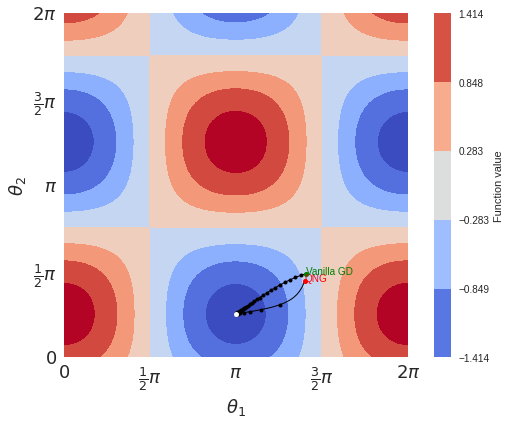

In [24]:
plt.style.use("seaborn")
fontsize = 18

fig, axes = plt.subplots(figsize=(8, 6))
cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta_firstv, theta_secondv, fn_values, extend='both',
                            cmap=cmap)

m = plt.cm.ScalarMappable(cmap=cm.coolwarm)
m.set_array(fn_values)
m.set_clim(np.min(fn_values), np.max(fn_values))
cbar = plt.colorbar(m, boundaries=np.linspace(np.min(fn_values), np.max(fn_values), 6))

cbar.ax.set_ylabel("Function value")

## Optimization path for QNG ##
 
# plot optimization path and every 10th point
plt.plot(qng_param_1_list, qng_param_2_list, 'k-', linewidth = 1)
plt.plot(plot_qng_param_1_list, plot_qng_param_2_list, 'ko', markersize = 4)

# plot and annotate start and end points
plt.plot(qng_param_1_list[0], qng_param_2_list[0], 'ro', markersize = 5)
plt.plot(qng_param_1_list[qng_steps], qng_param_2_list[qng_steps], 'wo', markersize = 5)

plt.annotate("QNG", (qng_param_1_list[0], qng_param_2_list[0]), color = 'r')

#plt.annotate("Start point", (qng_param_1_list[0], qng_param_2_list[0]), color = 'r')
#plt.annotate("End point", (qng_param_1_list[qng_steps], qng_param_2_list[qng_steps]), color = 'w')

## Optimization path for QNG ##
 
# plot optimization path and every 10th point
plt.plot(vanilla_param_1_list, vanilla_param_2_list, 'k-', linewidth = 1)
plt.plot(plot_vanilla_param_1_list, plot_vanilla_param_2_list, 'ko', markersize = 4)

# plot and annotate start and end points
plt.plot(vanilla_param_1_list[0], vanilla_param_2_list[0], 'go', markersize = 5)
plt.plot(vanilla_param_1_list[vanilla_steps], vanilla_param_2_list[vanilla_steps], 'wo', markersize = 5)

plt.annotate("Vanilla GD", (vanilla_param_1_list[0], vanilla_param_2_list[0]), color = 'g')

#plt.annotate("Start point", (vanilla_param_1_list[0], vanilla_param_2_list[0]), color = 'r')
#plt.annotate("End point", (vanilla_param_1_list[vanilla_steps], vanilla_param_2_list[vanilla_steps]), color = 'w')

## Set axis labels ##
axes.set_xticks([0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
axes.set_yticks([0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])

axes.set_xticklabels(["$0$", r"$\frac{1}{2}\pi$",
                     r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"], fontsize=fontsize)
axes.set_yticklabels(["$0$", r"$\frac{1}{2}\pi$",
                     r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"], fontsize=fontsize)
plt.xlabel(r'$\theta_1$', fontsize=fontsize)        
plt.ylabel(r'$\theta_2$', fontsize=fontsize)        

axes.set_aspect('equal')

plt.tight_layout()

### Bloch sphere visualization

1. Bloch sphere 1 is for QNG path
2. Bloch sphere 2 is for comparing QNG and Vanilla GD path

In [0]:
# quantum natural gradient statevectors for plotting
qng_plot_states = []
lst = qng_all_states

for i in range(len(lst)):
  psi = lst[i]
  psi = psi/np.linalg.norm(psi)

  # Convert to QObject in QuTiP
  coords = [qt.Qobj(psi)]

  qng_plot_states.append(coords)

# vanilla gradient descent statevectors for plotting
vanilla_plot_states = []
lst = vanilla_all_states

for i in range(len(lst)):
  vanilla_psi = lst[i]
  vanilla_psi = vanilla_psi/np.linalg.norm(vanilla_psi)

  # Convert to QObject in QuTiP
  coords = [qt.Qobj(vanilla_psi)]

  vanilla_plot_states.append(coords)

In [0]:
from qutip.expect import expect
from qutip.operators import sigmax, sigmay, sigmaz

qng_coords_x = []
qng_coords_y = []
qng_coords_z = []

for qobj in qng_plot_states:
    st = qobj
    x = expect(sigmax(), st)
    y = expect(sigmay(), st)
    z = expect(sigmaz(), st)

    for i in range(len(x)):
      x_list = x[i]
      qng_coords_x.append(x_list)

      y_list = y[i]
      qng_coords_y.append(y_list)

      z_list = z[i]
      qng_coords_z.append(z_list)

vanilla_coords_x = []
vanilla_coords_y = []
vanilla_coords_z = []

for qobj in vanilla_plot_states:
    st = qobj
    x = expect(sigmax(), st)
    y = expect(sigmay(), st)
    z = expect(sigmaz(), st)

    for i in range(len(x)):
      x_list = x[i]
      vanilla_coords_x.append(x_list)

      y_list = y[i]
      vanilla_coords_y.append(y_list)

      z_list = z[i]
      vanilla_coords_z.append(z_list)

In [0]:
# get every 10th statevector for plotting points on the descent path
qng_plot_points = qng_plot_states[::10]
vanilla_plot_points = vanilla_plot_states[::10]

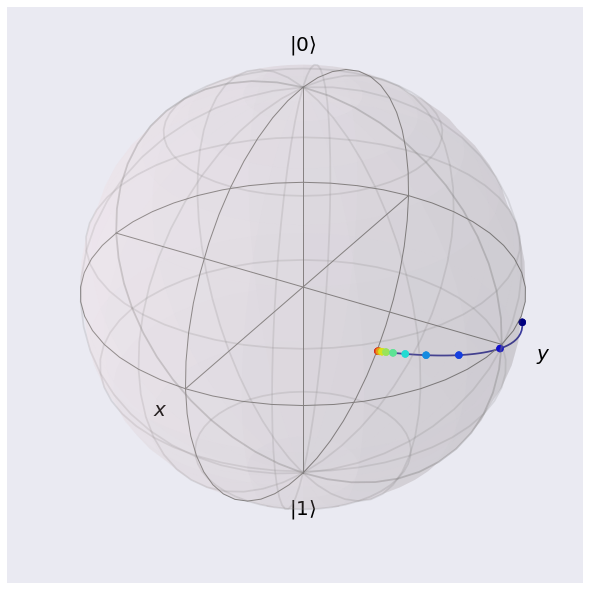

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

### Settings for Bloch sphere visualization  for QNG ###

b = Bloch()
b.sphere_alpha = 0.1
b.figsize = [8,8]

# normalize colors #
nrm = mpl.colors.Normalize(0, len(qng_plot_points))
colors = cm.jet(nrm(range(len(qng_plot_points))))
b.point_color = list(colors)
b.point_marker = 'o'
b.point_size = [50]

# Add points
b.add_states(qng_plot_points, 'point')

# Add line
b.add_points([qng_coords_x, qng_coords_y, qng_coords_z], 'l')


b.show()

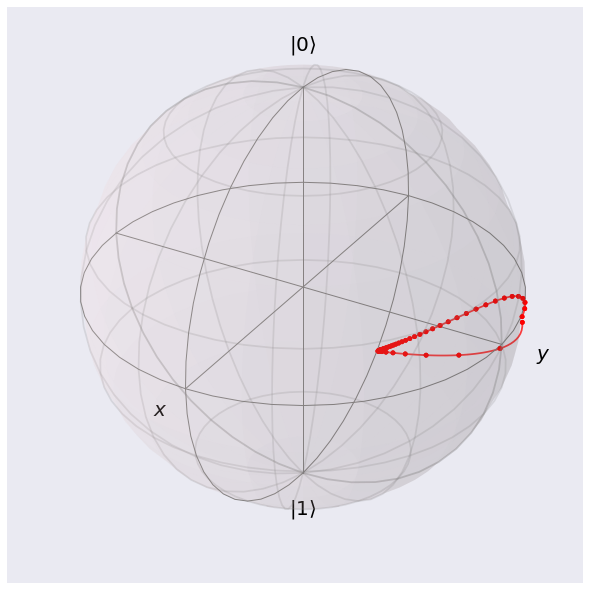

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

### Settings for Bloch sphere visualization  for QNG vs Vanilla GD ###

b = Bloch()
b.sphere_alpha = 0.1
b.figsize = [8,8]

# colors #
b.point_color = 'r'
b.point_marker = 'o'
b.point_size = [20]

# Add points
b.add_states(qng_plot_points, 'point')

# Add line
b.add_points([qng_coords_x, qng_coords_y, qng_coords_z], 'l')


### Settings for Bloch sphere visualization  for Vanilla ###

# Add points
b.add_states(vanilla_plot_points, 'point')

# Add line 
b.add_points([vanilla_coords_x, vanilla_coords_y, vanilla_coords_z], 'l')


b.show()